In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sentencepiece as spm
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

import re
import os
import random
import math

from tqdm.notebook import tqdm # 상태바 보여줌
import matplotlib.pyplot as plt

# Step 1. 데이터 다운로드

In [2]:
csv_path = 'ChatbotData.csv'

df= pd.read_csv(csv_path)
df

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


# Step 2. 데이터 정제
1. 영문자의 경우, 모두 소문자로 변환합니다.
2. 영문자와 한글, 숫자, 그리고 주요 특수문자를 제외하곤 정규식을 활용하여 모두 제거합니다.

문장부호 양옆에 공백을 추가하는 등 이전과 다르게 생략된 기능들은 우리가 사용할 토크나이저가 지원하기 때문에 굳이 구현하지 않아도 괜찮습니다!

In [3]:
# null
null = pd.DataFrame(df.dtypes, columns=['datatype'])
null = null.reset_index()
null['null count'] = df.isnull().sum().values
null['null ratio'] = null['null count']/df.shape[0]
null['unique count'] = df.nunique().values
print(df.shape)
null

(11823, 3)


,index,datatype,null count,null ratio,unique count
0,Q,object,0,0.0,11662
1,A,object,0,0.0,7779
2,label,int64,0,0.0,3


In [4]:
# duplicate
# 중복확인 >> 전체중복 없음, 칼럼중복 : 161, 4044개 >> 중복 드롭 안함
dupli = {}
dupli['dupli whole'] = df.duplicated().sum()
dupli['dupli Q columns'] = df.duplicated(subset=['Q']).sum()
dupli['dupli A columns'] = df.duplicated(subset=['A']).sum()
dupli_Q = df[df.duplicated(subset=['Q'])]
dupli_A = df[df.duplicated(subset=['A'])]
print(dupli)
dupli_Q

{'dupli whole': 0, 'dupli Q columns': 161, 'dupli A columns': 4044}


,Q,A,label
196,고양이 키우고 싶어,가족들과 상의해보세요.,0
235,공시 준비 힘들어,잘 될 거예요.,0
1294,돈 벌고 싶어,많이 벌수록 좋아요.,0
1445,로또 번호 알려줘,알면 제가 하죠.,0
1481,마음이 울적해,거리를 걸어보세요.,0
...,...,...,...
11642,착해서 잘해주는 건지 좋아하는 건지,헷갈린다고 말해보세요.,2
11649,첫 눈에 반하는게 가능해?,당연히 가능하죠.,2
11658,첫사랑 생각나,지금의 사랑에 충실하세요.,2
11732,커플여행이 나을까 그냥 우리끼리 갈까?,저는 둘이 가는 게 좋아요.,2


In [5]:
questions = [sentence for sentence in df['Q']]
answers = [sentence for sentence in df['A']]
print(type(questions))
print(len(questions))
print(len(answers))

<class 'list'>
11823
11823


In [6]:
import re
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!가-힣ㄱ-ㅎㅏ-ㅣ0-9]+", " ", sentence)
    return sentence

preprocess_sentence("11819 dd  훔쳐보는 것도 눈치 보임.")

'11819 dd 훔쳐보는 것도 눈치 보임 . '

# Step 3. 데이터 토큰화
토큰화에는 KoNLPy의 mecab 클래스를 사용합니다.  

아래 조건을 만족하는 build_corpus() 함수를 구현하세요!  

1. 소스 문장 데이터와 타겟 문장 데이터를 입력으로 받습니다. 
2. 데이터를 앞서 정의한 preprocess_sentence() 함수로 정제하고, 토큰화합니다.   
3. 토큰화는 전달받은 토크나이즈 함수를 사용합니다. 이번엔 mecab.morphs 함수를 전달하시면 됩니다.  
4. 토큰의 개수가 일정 길이 이상인 문장은 데이터에서 제외합니다.  
5. 중복되는 문장은 데이터에서 제외합니다. 소스 : 타겟 쌍을 비교하지 않고 소스는 소스대로 타겟은 타겟대로 검사합니다. 중복 쌍이 흐트러지지 않도록 유의하세요!  
6. 구현한 함수를 활용하여 questions 와 answers 를 각각 que_corpus , ans_corpus 에 토큰화하여 저장합니다.  

In [7]:
# 데이터의 몇프로인지 계산하는 함수

def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

MAX_LENGTH = 40
below_threshold_len(MAX_LENGTH, df['Q'])
below_threshold_len(MAX_LENGTH,  df['A'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 1.0
전체 샘플 중 길이가 40 이하인 샘플의 비율: 1.0


처음에 80% 정도만 하려고 조정을 하다가,, 데이터도 너무 적고, 최대 길이도 얼마되지 않아서 그냥 넉넉한 최대치로 lms와 동일하게 40을 줬다.

In [8]:
from konlpy.tag import Mecab

sequence_len = 40

def build_corpus(source, target, tokenizer):
    sents = list(zip(source, target))
    que_corpus, ans_corpus = [], []
    for sent in sents:
        que, ans = sent[0], sent[1]
        que = preprocess_sentence(que)
        ans = preprocess_sentence(ans)
        que_tokens = tokenizer(que)
        ans_tokens = tokenizer(ans)
        que_corpus.append(que_tokens)
        ans_corpus.append(ans_tokens)
    return que_corpus, ans_corpus

In [9]:
tokenizer = Mecab().morphs
que_corpus, ans_corpus = build_corpus(questions, answers, tokenizer)

In [10]:
print(que_corpus[:3])
print(ans_corpus[:3])
print(len(que_corpus),len(ans_corpus))

[['12', '시', '땡', '!'], ['1', '지망', '학교', '떨어졌', '어'], ['3', '박', '4', '일', '놀', '러', '가', '고', '싶', '다']]
[['하루', '가', '또', '가', '네요', '.'], ['위로', '해', '드립니다', '.'], ['여행', '은', '언제나', '좋', '죠', '.']]
11823 11823


# Step 4. Augmentation

우리에게 주어진 데이터는 1만 개가량으로 적은 편에 속합니다. 이럴 때에 사용할 수 있는 테크닉을 배웠으니 활용해 봐야겠죠? Lexical Substitution을 실제로 적용해 보도록 하겠습니다.

아래 링크를 참고하여 한국어로 사전 훈련된 Embedding 모델을 다운로드합니다. Korean (w) 가 Word2Vec으로 학습한 모델이며 용량도 적당하므로 사이트에서 Korean (w)를 찾아 다운로드하고, ko.bin 파일을 얻으세요!

Kyubyong/wordvectors
다운로드한 모델을 활용해 데이터를 Augmentation 하세요! 앞서 정의한 lexical_sub() 함수를 참고하면 도움이 많이 될 겁니다.

Augmentation된 que_corpus 와 원본 ans_corpus 가 병렬을 이루도록, 이후엔 반대로 원본 que_corpus 와 Augmentation된 ans_corpus 가 병렬을 이루도록 하여 전체 데이터가 원래의 3배가량으로 늘어나도록 합니다.

In [11]:
# pip install --upgrade gensim==3.8.3

In [12]:
import gensim
print(gensim.__version__)

3.8.3


In [13]:
file_path = 'ko.bin'
wv_model = gensim.models.Word2Vec.load(file_path)
print("wv 단어장 크기 :",len(wv_model.wv.vocab))

wv 단어장 크기 : 30185


In [14]:
wv_model.wv.most_similar("사랑")

[('슬픔', 0.7216662764549255),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985080718994),
 ('기쁨', 0.6458414196968079),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937275886536),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206069588661194),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

In [15]:
# 원본문장 + 증강문장 (n)
import random
def lexical_sub(toks, word2vec, num_aug):
    res = []
    res.append(toks)
    for _ in range(num_aug):
        try:
            _from = random.choice(toks)
            _to = word2vec.wv.most_similar(_from)[0][0]
        except:
            _stay = res.append(toks)
            continue
        new_toks = []
        for tok in toks:
            if tok == _from:
                new_toks.append(_to)
            
            else:
                new_toks.append(tok)
        res.append(new_toks)
    return res


In [16]:
a = ['12', '시', '땡', '!']
aug_a = lexical_sub(a,wv_model,2)
aug_a

[['12', '시', '땡', '!'], ['12', '시가', '땡', '!'], ['12', '시', '끗', '!']]

In [17]:
aug_que_corpus = []
for sentence in que_corpus:
    aug_sentences = lexical_sub(sentence, wv_model, 2)
    aug_que_corpus.extend(aug_sentences)

aug_ans_corpus = []
for sentence in ans_corpus:
    aug_sentences = lexical_sub(sentence, wv_model, 2)
    aug_ans_corpus.extend(aug_sentences)

In [18]:
print(len(aug_que_corpus), len(aug_ans_corpus))  
aug_ans_corpus[:33]

35469 35469


[['하루', '가', '또', '가', '네요', '.'],
 ['일주일', '가', '또', '가', '네요', '.'],
 ['하루', '놀드', '또', '놀드', '네요', '.'],
 ['위로', '해', '드립니다', '.'],
 ['무릎', '해', '드립니다', '.'],
 ['무릎', '해', '드립니다', '.'],
 ['여행', '은', '언제나', '좋', '죠', '.'],
 ['여행', '은', '언제나', '좋', '죠', '는데'],
 ['여행', '은', '언제나', '좋', '지요', '.'],
 ['여행', '은', '언제나', '좋', '죠', '.'],
 ['항해', '은', '언제나', '좋', '죠', '.'],
 ['항해', '은', '언제나', '좋', '죠', '.'],
 ['눈살', '이', '찌푸려', '지', '죠', '.'],
 ['눈살', '이', '찌푸려', '지', '지요', '.'],
 ['눈살', '이', '찌푸려', '지', '지요', '.'],
 ['다시', '새로', '사', '는', '게', '마음', '편해요', '.'],
 ['다시', '새로', '사', '는', '게', '마음', '편해요', '는데'],
 ['곧바로', '새로', '사', '는', '게', '마음', '편해요', '.'],
 ['다시', '새로', '사', '는', '게', '마음', '편해요', '.'],
 ['곧바로', '새로', '사', '는', '게', '마음', '편해요', '.'],
 ['다시', '새로', '사', 'ㄴ다는', '게', '마음', '편해요', '.'],
 ['잘', '모르', '고', '있', '을', '수', '도', '있', '어요', '.'],
 ['많이', '모르', '고', '있', '을', '수', '도', '있', '어요', '.'],
 ['잘', '모르', '기에', '있', '을', '수', '도', '있', '어요', '.'],
 ['시간', '을', '정하', '고',

In [19]:
aug_ans_corpus[:33]

[['하루', '가', '또', '가', '네요', '.'],
 ['일주일', '가', '또', '가', '네요', '.'],
 ['하루', '놀드', '또', '놀드', '네요', '.'],
 ['위로', '해', '드립니다', '.'],
 ['무릎', '해', '드립니다', '.'],
 ['무릎', '해', '드립니다', '.'],
 ['여행', '은', '언제나', '좋', '죠', '.'],
 ['여행', '은', '언제나', '좋', '죠', '는데'],
 ['여행', '은', '언제나', '좋', '지요', '.'],
 ['여행', '은', '언제나', '좋', '죠', '.'],
 ['항해', '은', '언제나', '좋', '죠', '.'],
 ['항해', '은', '언제나', '좋', '죠', '.'],
 ['눈살', '이', '찌푸려', '지', '죠', '.'],
 ['눈살', '이', '찌푸려', '지', '지요', '.'],
 ['눈살', '이', '찌푸려', '지', '지요', '.'],
 ['다시', '새로', '사', '는', '게', '마음', '편해요', '.'],
 ['다시', '새로', '사', '는', '게', '마음', '편해요', '는데'],
 ['곧바로', '새로', '사', '는', '게', '마음', '편해요', '.'],
 ['다시', '새로', '사', '는', '게', '마음', '편해요', '.'],
 ['곧바로', '새로', '사', '는', '게', '마음', '편해요', '.'],
 ['다시', '새로', '사', 'ㄴ다는', '게', '마음', '편해요', '.'],
 ['잘', '모르', '고', '있', '을', '수', '도', '있', '어요', '.'],
 ['많이', '모르', '고', '있', '을', '수', '도', '있', '어요', '.'],
 ['잘', '모르', '기에', '있', '을', '수', '도', '있', '어요', '.'],
 ['시간', '을', '정하', '고',

# Step 5. 데이터 벡터화
위 소스를 참고하여 타겟 데이터 전체에 토큰과 토큰을 추가해 주세요!
특수 토큰을 더함으로써 ans_corpus 또한 완성이 되었으니, que_corpus 와 결합하여 전체 데이터에 대한 단어 사전을 구축하고 벡터화하여 enc_train 과 dec_train 을 얻으세요!

In [20]:
que_corpus = aug_que_corpus
ans_corpus = aug_ans_corpus


In [21]:
print(len(que_corpus), len(ans_corpus))  

35469 35469


In [22]:
for index in range(len(que_corpus)):
    que_corpus[index] = ["<start>"] + que_corpus[index] + ["<end>"]

In [23]:
len(que_corpus)

35469

In [24]:
que_corpus[0]

['<start>', '12', '시', '땡', '!', '<end>']

1. 위 소스를 참고하여 타겟 데이터 전체에 \<start> 토큰과 \<end> 토큰을 추가해 주세요!  
    
챗봇 훈련 데이터의 가장 큰 특징 중 하나라고 하자면 바로 소스 데이터와 타겟 데이터가 같은 언어를 사용한다는 것이겠죠. 앞서 배운 것처럼 이는 Embedding 층을 공유했을 때 많은 이점을 얻을 수 있습니다.

2. 특수 토큰을 더함으로써 ans_corpus 또한 완성이 되었으니, que_corpus 와 결합하여 전체 데이터에 대한 단어 사전을 구축하고 벡터화하여 enc_train 과 dec_train 을 얻으세요!

In [44]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='',oov_token='<unk>')
tokenizer.fit_on_texts(que_corpus+ans_corpus)
enc_tensor = tokenizer.texts_to_sequences(que_corpus)
dec_tensor = tokenizer.texts_to_sequences(ans_corpus)

MAX_LEN = sequence_len + 2 # start, end 더해주기
enc_tensor = tf.keras.preprocessing.sequence.pad_sequences(enc_tensor, padding='post',maxlen=MAX_LEN)
dec_tensor = tf.keras.preprocessing.sequence.pad_sequences(dec_tensor, padding='post',maxlen=MAX_LEN)

VOCAB_SIZE = len(tokenizer.index_word)+1
print("VOCAB_SIZE:", VOCAB_SIZE) # 인덱스가 0부터 시작하므로

VOCAB_SIZE: 8235


In [45]:
print(enc_tensor.shape, dec_tensor.shape)

(35469, 42) (35469, 42)


In [64]:
BATCH_SIZE = 16
train_dataset = tf.data.Dataset.from_tensor_slices((enc_tensor, dec_tensor)).batch(batch_size=BATCH_SIZE)

# Step 6. 훈련하기

In [65]:
# Positional Encoding
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, (2*(i//2)) / np.float32(d_model))

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

In [66]:
# Mask 

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_lookahead_mask(size): 
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_enc_mask = generate_padding_mask(src)

    dec_lookahead_mask = generate_lookahead_mask(tgt.shape[1])
    dec_tgt_padding_mask = generate_padding_mask(tgt)
    dec_mask = tf.maximum(dec_tgt_padding_mask, dec_lookahead_mask)

    return enc_mask, dec_enc_mask, dec_mask

In [67]:
# Multi Head Attention 

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
        

    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x

    
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
                        
        out = self.combine_heads(out)
        out = self.linear(out)
            
        return out, attention_weights

In [68]:
# Position-wise Feed Forward Network

class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
            
        return out


In [69]:
# Encoder Layer

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        '''
        Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

In [70]:
# Decoder_Layer

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        '''
        Masked Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        '''
        Multi-Head Attention
        '''
        residual = out
        out = self.norm_2(out)
        # Q, K, V 순서에 주의하세요!
        out, dec_enc_attn = self.enc_dec_attn(Q=out, K=enc_out, V=enc_out, mask=dec_enc_mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [71]:
# Encoder

class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns


In [72]:
# Decoder

class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, dec_enc_mask, padding_mask)
            # encoder와 달리 mask 두 종류
            
            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [73]:
# Transformer 완전체
# 여기서 weight 공유하게 설정

class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)

        """
        1. Embedding Layer 정의 
        2. Positional Encoding 정의
        3. Encoder / Decoder 정의
        4. Output Linear 정의
        5. Shared Weights
        6. Dropout 정의
      
        인코터 임베딩(영어), 디코더 임베딩(스페인어), 출력층linear가
        같은 weight를 공유하려면, 임베딩을 공유해야 한다.
        여기서 if조건문은 임베딩을 공유하는 지금 case에 대한 것이고,
        else 조건문은 보통 encoder와 decoder의 임베딩을 share하지 않는
        한-영의 번역기 같은 경우이다.
        영어와 스페인어는 그 문자와 뜻이 거의 비슷해서 상위에서 공유하기로 했었다.
        """
        #################   #################     
        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)
        #################    #################    
        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, dec_enc_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, dec_enc_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [74]:
# 모델 인스턴스 생성

transformer = Transformer(
    n_layers=2,
    d_model=512,
    n_heads=8,
    d_ff=2048,
    src_vocab_size=VOCAB_SIZE,
    tgt_vocab_size=VOCAB_SIZE,
    pos_len=200,
    dropout=0.3,
    shared_fc=True,
    shared_emb=True)
		
d_model = 512

# 학습

In [75]:
# Learning Rate Scheduler
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

# learning_rate 선언
learning_rate = LearningRateScheduler(d_model)

In [76]:
# Optimizer

optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98, 
                                        epsilon=1e-9)

In [77]:
# Loss function

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [78]:
# train step 

@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  # Decoder의 input
    gold = tgt[:, 1:]     # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    # eval_step 부분을 여기 안으로 넣음
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

In [79]:
EPOCHS = 3

for epoch in range(EPOCHS):
    total_loss = 0
    
    dataset_count = tf.data.experimental.cardinality(train_dataset).numpy()
    tqdm_bar = tqdm(total=dataset_count)
    for step, (enc_batch, dec_batch) in enumerate(train_dataset):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_batch,
                    dec_batch,
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        tqdm_bar.set_description_str('Epoch %2d' % (epoch + 1))
        tqdm_bar.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (step + 1)))
        tqdm_bar.update()

  0%|          | 0/2217 [00:00<?, ?it/s]

  0%|          | 0/2217 [00:00<?, ?it/s]

  0%|          | 0/2217 [00:00<?, ?it/s]

# 평가하기

In [80]:
test_sentence = ['지루하다, 놀러가고 싶어.',
            '오늘 일찍 일어났더니 피곤하다.',
            '간만에 여자친구랑 데이트 하기로 했어.',
            '집에 있는다는 소리야.']

In [ ]:
#tokenizer = Mecab()

def src_tokenize(src, tokenizer,  enc_tokenizer, dec_tokenizer, maxlen= 17):
    
    src_id_sentences = []    
    
    for i, sen in enumerate(src):
        # 전처리
        src_sentence = preprocess_sentence(sen)    
        
        # 형태소분석기로 단어 토큰화
        src_token = tokenizer.morphs(src_sentence) 
        print("src_token",src_token)
        # 정수인덱스 벡터라이즈
        src_id_token = [enc_tokenizer.word_index[word] for word in src_token]
        print("src_id_token",src_id_token)
        # maxlen 이하 단어갖은 문장만 append
        if len(src_id_token) <= maxlen:
            src_id_sentences.append(src_id_token)
          
    return  src_id_sentences

In [ ]:
def translate(tokens, model, enc_tokenizer, dec_tokenizer, maxlen = 17):
    
    padded_tokens = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=maxlen,
                                                           padding='post')   #[tokens],
    ids = []
    output = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)   
    for i in range(maxlen):
        enc_padding_mask, combined_mask, dec_padding_mask = generate_masks(padded_tokens, output)

        predictions, _, _, _ = model(padded_tokens, 
                                      output,
                                      enc_padding_mask,
                                      combined_mask,
                                      dec_padding_mask)

        predicted_id = tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if dec_tokenizer.word_index['<end>'] == predicted_id:
            result = [dec_tokenizer.index_word[id] for id in ids]  
            return result

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result =  [dec_tokenizer.index_word[id] for id in ids]    
    return result

In [ ]:
def calculate_bleu(reference, candidate, weights=[0.25, 0.25, 0.25, 0.25]):
    return sentence_bleu([reference],
                         candidate,
                         weights=weights,
                         smoothing_function=SmoothingFunction().method1) 

In [ ]:
# 테스트문장으로 번역 실행

# 토크나이즈
que_id_sentences = src_tokenize(test_sentence, tokenizer,  enc_tokenizer, dec_tokenizer, maxlen=17)      
print("que_id_sentences",que_id_sentences, len(que_id_sentences))  
print()

# 번역
answer_results =[]
for tokens in que_id_sentences:
    ans_result = translate(tokens, transformer, enc_tokenizer, dec_tokenizer, maxlen=17)
    answer_results.append(ans_result)
print("answer_results", answer_results)

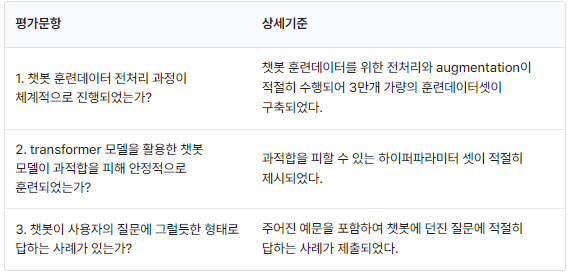